### S:RI Sampling

Goal: Count impressions for banner b.

I will assume S:RI only gets sent when the banner is shown (for simplicity and to model future (and expected) behavior). Lets define the following variables:

- t: some unit of time we are colecting data for
- n_b: number of impressions for banner b in time t
- n_i: number of impressions of any banner in time t
- n: number of requests (with and without SR:I) in time t
- r: sampling rate (e.g 0.01)




### Scenario 1: Filter on SRI, then sample at rate r: (

Let's ignore that sampling was done on an ordered stream of events. I will model things as we first collect all n_i S:RI requests in some urn (hint, hint) and then take n_i * r samples from the urn at random and without replacement. We count the number of impression for b in our sample. Our estimate for n_b will be that number divided by the sampling rate. This estimate follows a scaled version of the textbook [hypergeometric](https://en.wikipedia.org/wiki/Hypergeometric_distribution) distribution: $\frac{1}{r} * hypergeometric(n_b, n_i, n_i*r)$. 


In [1]:
from scipy.stats import hypergeom
import numpy as np 
from scipy.misc import comb as choose
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from stats_utils import bayesian_ci

    
def hypergeometric_sample( n_good, n_total, n_draws, n_samples = 100000):
    """
    Returns sample drawn hypergeometric distribution.
    """
    n = n_good
    M = n_total
    N = n_draws
    return hypergeom.rvs(M, n, N, size = n_samples)


def plot_sample(sample, theta):
    
    ci = bayesian_ci(sample, 95)
    rel_ci = ((ci[0] -theta )*100 / theta, ( ci[1] - theta)*100 / theta )
    plt.hist(sample, bins = 100)
    print ('True Value:' , n_b)
    print('Confidence Interval: ', ci)
    print('Confidence Interval on Relative Error: (%.2f%%, %.2f%%)' % rel_ci)
        
      
def plot_sample_dist_1(n_b, n_i, n, r):
    """
    Plots a sample (e.g approximate pmf) of a hypergeometric for scenario 1
    """
    sample = hypergeometric_sample(n_b, n_i, int(n_i*r))/r
    plot_sample(sample, n_b)
    
    

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 21 days


### Scenario 2: Sample at rate r: then filter on SRI

Let's again ignore that sampling was done on an ordered stream of events. This time I will model things as if every request is collected in an urn. We take n * r samples from the urn at random and without replacement and count those that correspond to an impression of banner b. As above, our estimate for n_b will that count divided by the sampling rate. The number items corresponding to a banner impression of b follows the distribution: $\frac{1}{r} *hypergeometric(n_b, n, n*r)$. 


In [2]:
def plot_sample_dist_2(n_b, n_i, n, r):    
    sample = hypergeometric_sample(n_b, n, int(n*r))/r
    plot_sample(sample, n_b)
    

Now we need to model some realistic testing scenarios:

### Short 100% test, CN Running Mainly just for this test

In [3]:
n_b = 150000

p_i = 0.001 # fraction of requests that are S:RI (this is a quess)
p_i_b = 0.90 # fraction of impression from this banner

n_i = int(n_b / p_i_b)
n = int(n_i / p_i)
r = 1./100

print ('Num Requests: %d' % n)
print ('Num S:RI: %d' % n_i)
print ('Num impressions: %d' % n_b)

Num Requests: 166666000
Num S:RI: 166666
Num impressions: 150000


True Value: 150000
Confidence Interval:  (147500.0, 152300.0)
Confidence Interval on Relative Error: (-1.67%, 1.53%)


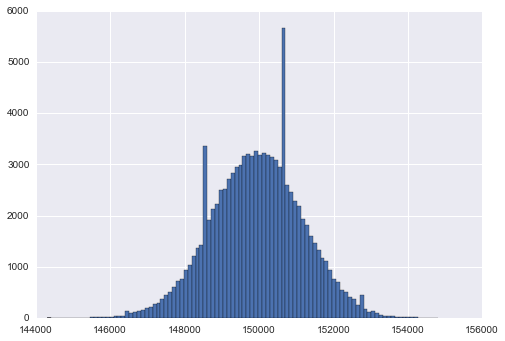

In [4]:
plot_sample_dist_1(n_b, n_i, n, r)

True Value: 150000
Confidence Interval:  (142500.0, 157600.0)
Confidence Interval on Relative Error: (-5.00%, 5.07%)


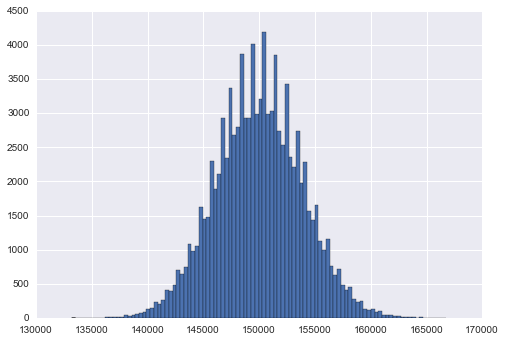

In [5]:
plot_sample_dist_2(n_b, n_i, n, r)

Here method 1 gives significanlty better results. I would say the accuracy of method 2 is unacceptable.

### Short 100% test, CN running several campaigns

In [6]:
n_b = 150000

p_i = 0.001 # fraction of requests that are S:RI (this is a quess)
p_i_b = 0.1 # fraction of impression from this banner

n_i = int(n_b / p_i_b)
n = int(n_i / p_i)
r = 1./100

print ('Num Requests: %d' % n)
print ('Num S:RI: %d' % n_i)
print ('Num impressions: %d' % n_b)

Num Requests: 1500000000
Num S:RI: 1500000
Num impressions: 150000


True Value: 150000
Confidence Interval:  (142900.0, 157300.0)
Confidence Interval on Relative Error: (-4.73%, 4.87%)


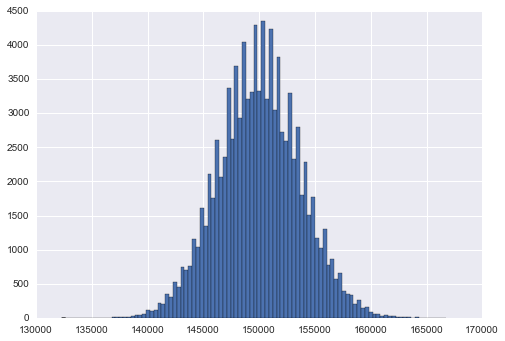

In [7]:
plot_sample_dist_1(n_b, n_i, n, r)

True Value: 150000
Confidence Interval:  (142500.0, 157600.0)
Confidence Interval on Relative Error: (-5.00%, 5.07%)


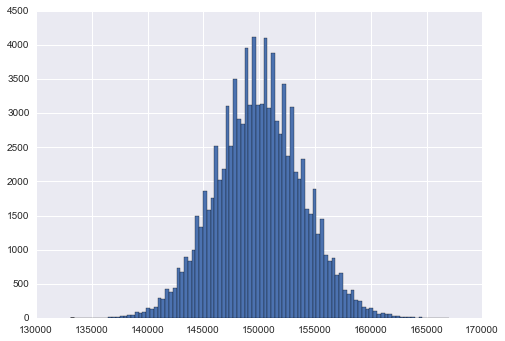

In [8]:
plot_sample_dist_2(n_b, n_i, n, r)

Here the 2 methods are comparable and equally unacceptable.

# What if S:RI takes up a much smaller fraction of all requests

In [12]:
n_b = 150000

p_i = 0.0001 # fraction of requests that are S:RI (this is a quess)
p_i_b = 0.1 # fraction of impression from this banner

n_i = int(n_b / p_i_b)
n = int(n_i / p_i)
r = 1./100

print ('Num Requests: %d' % n)
print ('Num S:RI: %d' % n_i)
print ('Num impressions: %d' % n_b)

Num Requests: 15000000000
Num S:RI: 1500000
Num impressions: 150000


True Value: 150000
Confidence Interval:  (142900.0, 157200.0)
Confidence Interval on Relative Error: (-4.73%, 4.80%)


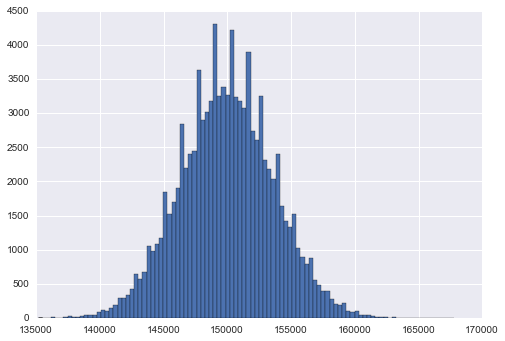

In [13]:
plot_sample_dist_1(n_b, n_i, n, r)

True Value: 150000
Confidence Interval:  (142500.0, 157600.0)
Confidence Interval on Relative Error: (-5.00%, 5.07%)


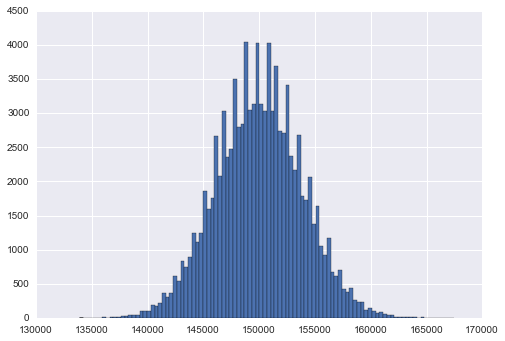

In [14]:
plot_sample_dist_2(n_b, n_i, n, r)

This change did not make a real difference

# What if we sample at a lower rate?

In [16]:
n_b = 150000

p_i = 0.001 # fraction of requests that are S:RI (this is a quess)
p_i_b = 0.1 # fraction of impression from this banner

n_i = int(n_b / p_i_b)
n = int(n_i / p_i)
r = 1./5

print ('Num Requests: %d' % n)
print ('Num S:RI: %d' % n_i)
print ('Num impressions: %d' % n_b)

Num Requests: 1500000000
Num S:RI: 1500000
Num impressions: 150000


True Value: 150000
Confidence Interval:  (148560.0, 151445.0)
Confidence Interval on Relative Error: (-0.96%, 0.96%)


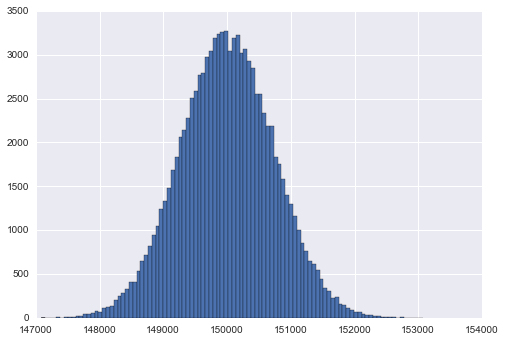

In [17]:
plot_sample_dist_1(n_b, n_i, n, r)

True Value: 150000
Confidence Interval:  (148485.0, 151510.0)
Confidence Interval on Relative Error: (-1.01%, 1.01%)


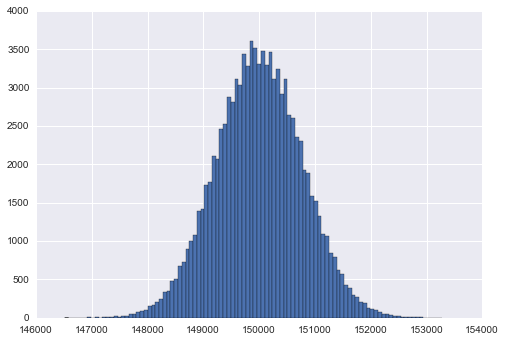

In [18]:
plot_sample_dist_2(n_b, n_i, n, r)

This is looking much better. I recommend going with sampling rate of around 1:5.

# Scratch Code

In [104]:
def hypergeometric_pmf( n_good, n_total, n_draws):
    """
    Returns full probability mass function (pmf) of hypergeometric distribution.
    """
    n = n_good
    M = n_total
    N = n_draws
    ks = list(range (max(0, N - (M-n)),  min(n, N)+1))
    pmf = [hypergeom.pmf(k, M, n, N) for k in ks]
    return ks, pmf

def plot_pmf(xs, ys, thresh = 0.0001):
    """
    Plots pmf but only includes reasonable values
    """
    xs_feasible = []
    ys_feasible = []
    for i, y in enumerate(ys):
        if y > thresh:
            xs_feasible.append(xs[i])
            ys_feasible.append(ys[i])
        
    plt.plot(xs_feasible, ys_feasible )
    
    
def plot_pmf_dist_1(n_b, n_i, n, r):
    """
    Plot the pmf of a hypergeometric for scenario 1. Is exact, but can be very slow
    """
    xs, ys = hypergeometric_pmf(n_b, n_i, int(n_i*r))
    xs = [x/r for x in xs]
    plot_pmf(xs, ys)
    
def plot_pmf_dist_2(n_b, n_i, n, r):
    xs, ys = hypergeometric_pmf(n_b, n, int(n*r))
    xs = [x/r for x in xs]
    plot_pmf(xs, ys)